In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import Levenshtein
import time
import torchaudio
import librosa

from morse.models import CNNResidualBlock, TransformerResidualBlock, PoolingTransition, CNNTransformer, CTCHead
from morse.models import MySomething
from morse.models import SimpleCNN
from morse.my_datasets import ListDataset, load_tensors, filenames_to_torch
from morse.samplers import LongCTCSampler
from morse.augmentations import rotation_transform, volume_signal_transform
from morse.text_helpers import Vectorizer, encode_to_morse, decode_from_morse

from morse.my_datasets import generate_dataset, read_dataset_from_files
from morse.generators import volume_sinusoid_variation

In [2]:
labels_dir = '../'
audio_dir = '../morse_dataset'


dev_flag = True

fake_dataset_size = 1000 if dev_flag else 30000 

full_train_df = pd.read_csv(Path(labels_dir, 'train.csv'))
test_df = pd.read_csv(Path(labels_dir, 'test.csv'))
full_train_df.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


# synthetic

In [3]:
fake_train_set = generate_dataset(fake_dataset_size, runtime_transform=rotation_transform)
fake_val_set = generate_dataset(5000)

100%|██████████| 5000/5000 [00:19<00:00, 258.37it/s]


100%|██████████| 100/100 [00:00<00:00, 323.63it/s]


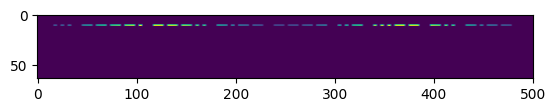

In [4]:
# fake_batch = torch.stack([fake_train_set[0][0], fake_train_set[1][0], fake_train_set[2][0]])
# print(fake_batch.shape)



fake_mel, fake_message = generate_dataset(100, signal_transform=volume_signal_transform, runtime_transform=rotation_transform)[0]
plt.imshow(fake_mel)
plt.show()

# real

In [4]:
from sklearn.model_selection import train_test_split

train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)
real_val_set = read_dataset_from_files(audio_dir, 
                                       filenames = full_train_df.iloc[val_index]['id'], 
                                       labels=list(full_train_df.iloc[val_index]['message']))
print(len(real_val_set))

100%|██████████| 5000/5000 [00:47<00:00, 105.59it/s]

5000


# some helpers

In [5]:
index_to_letter = sorted(set(''.join(full_train_df['message'])))
pad_value = 0
print(index_to_letter)
letter_to_index = dict([(letter, i) for i, letter in enumerate(index_to_letter)])
dictionary_size = len(index_to_letter)
print(dictionary_size)
print(letter_to_index)

vectorizer = Vectorizer(letter_to_index, index_to_letter)
print(vectorizer.text_transform('ПРИВЕТ #'))


def batch_text_transform(texts):
    vecs, lengths = vectorizer.batch_text_transform(texts, pad_value=pad_value)
    return vecs + 1, lengths

[' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
44
{' ': 0, '#': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'А': 12, 'Б': 13, 'В': 14, 'Г': 15, 'Д': 16, 'Е': 17, 'Ж': 18, 'З': 19, 'И': 20, 'Й': 21, 'К': 22, 'Л': 23, 'М': 24, 'Н': 25, 'О': 26, 'П': 27, 'Р': 28, 'С': 29, 'Т': 30, 'У': 31, 'Ф': 32, 'Х': 33, 'Ц': 34, 'Ч': 35, 'Ш': 36, 'Щ': 37, 'Ъ': 38, 'Ы': 39, 'Ь': 40, 'Э': 41, 'Ю': 42, 'Я': 43}
tensor([27, 28, 20, 14, 17, 30,  0,  1])


In [9]:
device = 0 if torch.cuda.is_available() else 'cpu'
device

'cpu'

# model

In [10]:
n_epochs = 30
batch_size = 128

lr = 0.005
step_gamma = 0.359
dropout = 0.165

n_pools = 4
n_blocks_before_pool = 3
pooling_overlap = True

group = 'FreshStart'
run_name = 'testing'

config = {
    'n_epochs': n_epochs,
    'batch_size': batch_size,
    
    'lr': lr,
    'step_gamma': step_gamma,
    'dropout': dropout,

    'n_pools': n_pools,
    'n_blocks_before_pool': n_blocks_before_pool,
    'pooling_overlap': pooling_overlap,
}

In [11]:
model = SimpleCNN(d_input=64, d_model=64, d_inner=64, d_output=dictionary_size + 1, 
                  n_pools=n_pools, n_blocks_before_pool=n_blocks_before_pool, pooling_overlap=True, dropout=dropout)

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=step_gamma)
ctc_loss = nn.CTCLoss()


fake_train_loader = torch.utils.data.DataLoader(fake_train_set, batch_size=batch_size, shuffle=True)
fake_val_loader = torch.utils.data.DataLoader(fake_val_set, batch_size=batch_size, shuffle=False)
real_val_loader = torch.utils.data.DataLoader(real_val_set, batch_size=batch_size, shuffle=False)

# with wandb.init(
#         **common_wandb_kvals,
#         group=group,
#         config=config,
#         name=run_name,
#         ) as run:
for epoch in range(n_epochs):
    model.train()
    fake_train_loss_buffer = []
    for features, labels in tqdm(fake_train_loader):
        features = features.to(device)
        targets, target_lengths = batch_text_transform(labels)
        targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
        outs = model(features).transpose(0, 2).transpose(1, 2)
        inputs = F.log_softmax(outs, dim=2)
        input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
        loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        fake_train_loss_buffer.append(loss.detach())
    scheduler.step()

    model.eval()
    fake_val_loss_buffer = []
    with torch.no_grad():
        for features, labels in tqdm(fake_val_loader):
            features = features.to(device)
            targets, target_lengths = batch_text_transform(labels)
            targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
            outs = model(features).transpose(0, 2).transpose(1, 2)
            inputs = F.log_softmax(outs, dim=2)
            input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
            loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
            fake_val_loss_buffer.append(loss.detach())
    
    # model.eval()
    # real_val_loss_buffer = []
    # with torch.no_grad():
    #     for features, labels in tqdm(real_val_loader):
    #         features = features.to(device)
    #         targets, target_lengths = batch_text_transform(labels)
    #         targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
    #         outs = model(features).transpose(0, 2).transpose(1, 2)
    #         inputs = F.log_softmax(outs, dim=2)
    #         input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
    #         loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
    #         real_val_loss_buffer.append(loss.detach())

    fake_train_loss_value = torch.mean(torch.stack(fake_train_loss_buffer)).item()
    fake_val_loss_value = torch.mean(torch.stack(fake_val_loss_buffer)).item()
    # real_val_loss_value = torch.mean(torch.stack(real_val_loss_buffer)).item()

    print('train: ', fake_train_loss_value)
    print('test:  ', fake_val_loss_value)
    # print('real val', real_val_loss_value)
        # wandb.log({
        #     'train_loss': train_loss_value,
        #     'test_loss': test_loss_value,
        #     'lr': scheduler.get_last_lr()[0],
        # })

100%|██████████| 40/40 [00:09<00:00,  4.16it/s]


train:  4.478435516357422
test:   4.998063087463379
real val 5.633488655090332


100%|██████████| 40/40 [00:08<00:00,  4.59it/s]


train:  3.101802349090576
test:   4.100996971130371
real val 7.176459312438965


100%|██████████| 40/40 [00:08<00:00,  4.50it/s]


train:  2.5137369632720947
test:   2.7605419158935547
real val 7.856261253356934


100%|██████████| 40/40 [00:08<00:00,  4.55it/s]


train:  1.9083642959594727
test:   1.747704267501831
real val 10.543474197387695


100%|██████████| 40/40 [00:08<00:00,  4.54it/s]


train:  1.2899998426437378
test:   1.0219135284423828
real val 11.543412208557129


100%|██████████| 40/40 [00:09<00:00,  4.34it/s]


train:  0.8050808310508728
test:   0.6387902498245239
real val 10.309587478637695


100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


train:  0.5655008554458618
test:   0.5640571117401123
real val 10.828984260559082


100%|██████████| 40/40 [00:08<00:00,  4.58it/s]


train:  0.42763668298721313
test:   0.4274771809577942
real val 11.7359037399292


100%|██████████| 40/40 [00:08<00:00,  4.59it/s]


train:  0.34071239829063416
test:   0.4081993103027344
real val 11.37490463256836


 75%|███████▌  | 6/8 [00:05<00:01,  1.11it/s]


KeyboardInterrupt: 

In [14]:
star_filenames = test_df['id'][-17:][:6]
star_morse = [
    '-.. .- -- .. -. .- -- - / -.. --- - .. / .-. ... -.-- ... .- -- -.-. ..',
    '.. .-.. / -..- ... .-- . -.. - -.- ---. .-- -. - .. / .-.- -- -.. -- -.-- -- ..-- -. .-.- -- -.-. / ..-- - .. -.-- -- -..- - -.- - ---. -- -.-- -. / -.. - -.-- -- .-. --. --.. / . .--. .. --.',
    '.- -. .... / .-- ... --- . --. -..- / .-. / .-- -.- - -.. .- -- .. / -. -.- ---- -- -.. -. .. / --. . -.- -. ...- - .-',
    '.. .-.. / -.. .- ... -.. .--. / -..- ... --- . -- ..- -. - .. / .. --. .-- -.- ... --- . .--. / -..- -.- ... .... -.-- ... ..- ... / .... -. ..- / ..-- -. / .... -. .... -. ..- ... ..',
    '. - -..- - -.- .--. / -.. ... .-.- -. -.- -- -.-- --- -.-. / .. -- -.-',
    '-.- -. --- -..- -.- -- / ... --- . -. -.-- -- --- .--. / -..- ... ..-- -. .-- --',
]
star_dataset = read_dataset_from_files(audio_dir, filenames=star_filenames, labels=[decode_from_morse(m) for m in star_morse])

100%|██████████| 6/6 [00:00<00:00, 16.22it/s]


In [28]:
model.eval()
star_loss_buffer = []
star_len_buffer = []
with torch.no_grad():
    for features, labels in tqdm(star_dataset):
        features = features[None]
        labels = [labels]
        features = features.to(device)
        targets, target_lengths = batch_text_transform(labels)
        targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
        outs = model(features).transpose(0, 2).transpose(1, 2)
        inputs = F.log_softmax(outs, dim=2)
        input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
        loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
        star_len_buffer.append(len(labels[0]))
        star_loss_buffer.append(loss.detach())
print(torch.mean(torch.stack(star_loss_buffer, dim=0)).item())
print(np.mean(star_len_buffer))

100%|██████████| 6/6 [00:00<00:00, 67.49it/s]

6.236782550811768
34.166666666666664


ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМЬТКТЧМЫН ДТЫМРГЗ ЕПИГ
.. .-.. / -..- ... .-- . -.. - -.- ---. .-- -. - .. / .-.- -- -.. -- -.-- -- ..-- -. .-.- -- -.-. / ..-- - .. -.-- -- -..- - -.- - ---. -- -.-- -. / -.. - -.-- -- .-. --. --.. / . .--. .. --.


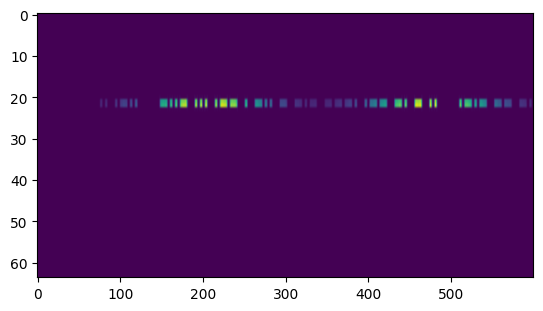

In [18]:
star_mel, star_message = star_dataset[1]

print(star_message)
print(encode_to_morse(star_message))
plt.imshow(star_mel[:, :600], aspect=5)

In [ ]:
torch.save(model.state_dict(), f'{run_name}.pt')